# Causal effect variational autoencoder

## Outline

- [Setup](#setup)
- [Overview: Proxy variables and latent confounders](#overview:-proxy-variables-and-latent-confounders)
    - [Task: Treatment effect estimation with observational data](#task:-treatment-effect-estimation-with-observational-data)
    - [Challenge: Confounding](#challenge:-confounding)
    - [Assumptions: All latent confounders influence at least one "proxy" covariate](#assumptions:-all-latent-confounders-influence-at-least-one-\"proxy\"-covariate)
    - [Intuition: Adjusting for confounding via proxies](#intuition:-adjusting-for-confounding-via-proxies)
- [Example: Synthetic data](#example:-synthetic-data)
- [Causal Probabilistic Program](#causal-probabilistic-program)
    - [Model Description](#model-description)
    - [Prior Description](#prior-description)
- [Causal Query: conditional average treatment effect (CATE)](#causal-query:-conditional-average-treatment-effect-\(CATE\))
    - [Fit parameter via maximum likelihood](#fit-parameters-via-maximum-likelihood)
- [Causal Inference as Probabilistic Inference](#causal-inference-as-probabilistic-inference)
- [Results](#results)


## Setup

Here, we install the necessary Pytorch, Pyro, and ChiRho dependencies for this example.

In [1]:
%reload_ext autoreload
%autoreload 2
%pdb off

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import pytorch_lightning as pl

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule

from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather
from chirho.interventional.handlers import do
from chirho.observational.handlers import condition

torch.set_float32_matmul_precision('medium')
pyro.clear_param_store()
pyro.set_rng_seed(1234)
pyro.settings.set(module_local_params=True)

Automatic pdb calling has been turned OFF


## Overview: Proxy variables and latent confounders

### **Task:** Treatment effect estimation with observational data

Just as in the [backdoor](backdoor.ipynb) and [slc](slc.ipynb) examples, in this example we are interested in estimating how changes (or interventions) to a particular treatment variable $T$ influence a particular outcome variable $Y$. We wish to estimate this causal effect using *observational* (non-randomized) data from $T$, $Y$, and some collection of covariates $X =\{X_1, ..., X_d\}$.

### **Challenge:** Confounding

As the task here is exactly identical to the [backdoor](backdoor.ipynb) and [slc](slc.ipynb) examples, so too are the challenges. From the [backdoor](backdoor.ipynb) example: 

"Unfortunately, naively estimating the effect of an intervention by simply approximating $P(Y|T)$ alone may produce poor estimates of $T$'s effect on $Y$."

Note: While the challenges remain the same between these examples, the assumptions we make will differ substantially.

### **Assumptions:** All latent confounders influence at least one "proxy" covariate

In the [backdoor](backdoor.ipynb) example we saw how to estimate causal effects from observational data when all confounders were observed. In the [slc](slc.ipynb) example we softened this assumption, instead allowing some latent confounders to be shared between instances (e.g. students) belonging to the same object (e.g. school). In this example we again soften the restrictive assumptions made in the [backdoor](backdoor.ipynb) example, however using a different assumption about the relationship between potential latent confounders $Z$ and data $T$, $Y$, and $X$.

Specifically, in this example we assume that every latent confounder $Z_i \in Z$ is a cause of at least one "proxy" covariate $X_j \in X$, $1 \leq j \leq d$. See Figure 1 in Louizos et al. [louizos2017causal] for a graphical description of these assumptions.

Importantly, in this work we do not wish to make strong parameteric assumptions (e.g. linear structural functions) relating latent confounders, proxy covariates, treatment, and outcome. As we'll see later, we can instead approximate these local causal dependencies using probabilistic models with neural network components.

**Note:** In the original paper introducing the CEVAE model [louizos2017causal], the authors prove a theorem (Theorem 1) stating that the conditional average treatment effect is identifiable if the model is correctly specified, including a strong assumption about the marginal distribution over latent confounders $Z$. Recent work [rissanen2021critical] has investigated the consequences of misspecifying components of the CEVAE model, concluding that its derived causal estimate are in fact sensitive to these detailed assumptions about the generative model. While some more restrictive settings may yield more robust identification results or bounds on causal effects (e.g. binary variables [kuroki2014measurement]), to the best of our knowledge little more is known about the nonparametric or semiparametric settings.

### **Intuition:** Adjusting for confounding via proxies

In the [backdoor](backdoor.ipynb) tutorial we discussed how to estimate causal effects with observational data by partitioning individual units into nonoverlapping subgroups such that each subgroup had similar or identical values of observed covariates $X$. When all confounders are observed, "adjusting for" confounders in this way produces unbiased estimates of the population-level causal effects we are interested in. However, this is not the case when some confounders are latent.

In this example we have made an additional assumption that all latent confounders causally influence at least one observed covariate, which we call "proxy confounders". Imagine for moment a scenario where this causal relationship is deterministic, bijective, and smooth. In this idealized scenario partitioning groups of individuals based on observed covariates $X$ produces groups that are equivalent to those we would have produced if the latent confounders $Z$ were in fact observed. This is true even though we don't know the true assignments of $Z$ for our observed data; as every subgroup will have similar values by construction. 

In practice, the relationship between latent confounders and observed covariates never satisfies this idealized deterministic property. Instead, the CEVAE model includes an explicitly probabilistic relationship between latent confounders and observed covariates, using neural network components as function approximators. With the previous caveat about identifiability and robustness of the CEVAE model aside, we can intuit that conditioning on these proxy confounders will update our posterior beliefs about which latent confounders are similar to each other, albiet without absolute certainty.

## Example: Synthetic Data

In this example we'll use synthetic data to demonstrate the CEVAE model. Here we generate observed and counterfactual data, which can then be used to compute a "ground truth" treatment effect for us to compare against when we use ChiRho for causal inference later.

In [2]:
num_train, num_test = 10000, 2000
feature_dim = 10
z_gap = 1.
y_gap = 3.

def generate_data(num_data, feature_dim, z_gap, y_gap):
    # Latent confounder z is binary.
    z = dist.Bernoulli(0.5).sample([num_data])

    # Covariates x are normally distributed, with higher variance for z=1.
    x = dist.Normal(z * z_gap, 5 * z + 3 * (1 - z)).sample([feature_dim]).t()

    # Treatment t is binary, with higher probability for z=1.
    t = dist.Bernoulli(0.75 * z + 0.25 * (1 - z)).sample()

    # Outcome y is binary, with higher probability for z=1 and t=1.
    y = dist.Bernoulli(logits=y_gap * (z + 2 * (2 * t - 1))).sample()

    # Compute true c-specific CATE for evaluation.
    t0_t1 = torch.tensor([[0.0], [1.0]])
    y_t0, y_t1 = dist.Bernoulli(logits=y_gap * (z + 2 * (2 * t0_t1 - 1))).mean
    true_cates = y_t1 - y_t0
    return x, t, y, z, true_cates

# Note: In the CEVAE paper they refer to c-specific causal effects as individual treatment effects.
# We use the term c-specific causal effects to be consistent with the terminology in the broader causal inference literature.
# with torch.no_grad():
x_train, t_train, y_train, _, _ = generate_data(num_train, feature_dim, z_gap, y_gap)
x_test, _, _, z_test, true_cates = generate_data(num_test, feature_dim, z_gap, y_gap)

## Causal Probabilistic Program

Our causal assumptions can be encoded as a probabilistic program in Pyro. Here, unlike the [backdoor](backdoor.ipynb) and [slc](slc.ipynb) tutorials, we'll perform maximum likelihood inference over neural network parameters, and then only later use variational approximations for the latent proxy confounders $Z$.

### Model Description

Our model captures the intuition that our three observed variables, $X$, $t$, and $y$, may be correlated, thanks to unobserved confounders $z$. Here, $f$, $g$, and $h$ are neural networks parameterized by different parts of the parameter set $\theta$, which are implicitly defined when the neural network modules are instantiated. As you can see in the automatically constructed rendering below, our probabilistically program model is faithful to the assumed causal structure in the CEVAE paper [louizos2017causal].

**Note:** In the CEVAE paper the authors propose a more sophisticated inference scheme using both a probabilsitic encoder and decoder network. Here, we simply show maximum likelihood estimation for brevity, but one could straightforwardly extend this example to include the full VAE training infrastructure using Pyro.

### Prior Description

As we only apply maximum likelihood inference in this example, we do not place priors on any of the latent parameters in the CEVAE model.

In [3]:
class FullyConnected(nn.Sequential):
    # Fully connected neural network with ELU activations.
    def __init__(self, sizes):
        layers = []
        for in_size, out_size in zip(sizes, sizes[1:]):
            layers.append(nn.Linear(in_size, out_size))
            layers.append(nn.ELU())
        layers.pop(-1)
        super().__init__(*layers)


class DiagNormalNet(FullyConnected):
    # Fully connected neural network with ELU activations, followed by a diagonal Gaussian.
    def __init__(self, sizes):
        assert len(sizes) >= 2
        sizes = sizes[:-1] + [sizes[-1] * 2]
        super().__init__(sizes)

    def forward(self, x):
        loc, scale = super().forward(x).chunk(2, dim=-1)
        return loc, nn.functional.softplus(scale)


class BernoulliNet(FullyConnected):
    # Fully connected neural network with ELU activations, followed by a Bernoulli.
    def __init__(self, sizes):
        super().__init__(sizes + [1])

    def forward(self, x):
        return super().forward(x).squeeze(-1).clamp(min=-10, max=10)


class PreWhitener(nn.Module):
    """
    Data pre-whitener.
    """
    def __init__(self, data):
        super().__init__()
        with torch.no_grad():
            loc = data.mean(0)
            scale = data.std(0)
            scale[~(scale > 0)] = 1.0
            self.register_buffer("loc", loc)
            self.register_buffer("inv_scale", scale.reciprocal())

    def forward(self, data):
        return (data - self.loc) * self.inv_scale

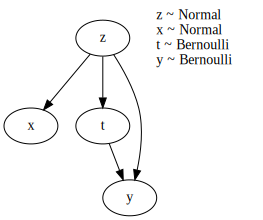

In [4]:
class ProxyConfounderModel(PyroModule):
    """
    :param dict config: A dict specifying ``feature_dim``, ``latent_dim``,
        ``hidden_dim``, ``num_layers``, and ``outcome_dist``.
    """

    def __init__(self, feature_dim: int, latent_dim: int, hidden_dim: int, num_layers: int):
        super().__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.feature_dim = feature_dim
        self.register_buffer("zero", torch.tensor(0.))
        self.register_buffer("one", torch.tensor(1.))
        self.x_nn = DiagNormalNet([latent_dim] + [hidden_dim] * num_layers + [feature_dim])
        self.t_nn = BernoulliNet([latent_dim])
        # The y network is split between the two t values.
        self.y0_nn = BernoulliNet([latent_dim] + [hidden_dim] * num_layers)
        self.y1_nn = BernoulliNet([latent_dim] + [hidden_dim] * num_layers)

    def forward(self):
        # Proxy confounder
        z = pyro.sample("z", dist.Normal(self.zero, self.one).expand([self.latent_dim]).to_event(1))
        # Observed covariates
        x = pyro.sample("x", dist.Normal(*self.x_nn(z)).to_event(1))
        # Treatment
        t = pyro.sample("t", dist.Bernoulli(logits=self.t_nn(z)))
        # parameters are not shared among values of t
        y_logits = torch.where(t == 1, self.y1_nn(z), self.y0_nn(z))
        # Outcome
        y = pyro.sample("y", dist.Bernoulli(logits=y_logits))
        return y


individual_model = ProxyConfounderModel(
    feature_dim=x_train.shape[-1],
    latent_dim=5,
    hidden_dim=200,
    num_layers=3,
)
pyro.render_model(individual_model, render_distributions=True)

## Causal Query: conditional average treatment effect (CATE)

In this setting we wish to compute the *conditional average treatment effect*, $CATE = \mathbb{E}[Y=1|do(T=1), X=x] - \mathbb{E}[Y=1|do(T=0), X=x]$. The `do` notation indicates that the expectations are taken according to *intervened* versions of the model, with $T$ set to a particular value. Note from our [tutorial](tutorial_i.ipynb) that this is different from conditioning on $T$ in the original `causal_model`, which assumes $Z$ and $T$, and thus $X$ and $Y$ are dependent.

In words, in this setting the CATE tells us how much greater the outcome would be across all individuals with the same set of covariates if we forced those individuals to receive treatment relative to if we forced them to not receive treatment. Here, we are interested in the average only over that subpopulation of individuals with the same value of the covariates. 

As we're using maximum likelihood inference here, we'll first condition our model to update neural network parameters, and then afterwards transform the model with learned parameters according to the desired intervention. This two-stage procedure separates the computation for convenience, but could instead be implemented in a single inference run in an extended model like the [backdoor](backdoor.ipynb) and [slc](slc.ipynb) models.

### Fit parameters via maximum likelihood

Before estimating the query, we fit deterministic neural network parameters in the model to the observed data via maximum likelihood.

First, we must extend the model over individual instances to be a model over the entire population using Pyro's `plate` effect handler.

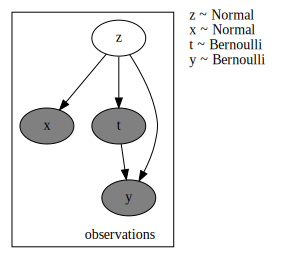

In [5]:
class CEVAE_Population(PyroModule):
    def __init__(self, individual_model: ProxyConfounderModel):
        super().__init__()
        self.individual_model = individual_model

    def forward(self, x_obs, t_obs, y_obs):
        # Condition on observed x, t, y
        # Use a plate to indicate that the following observations
        #   are conditionally independent given NN parameters.
        with condition(data=dict(x=x_obs, t=t_obs, y=y_obs)), \
                pyro.plate("observations", size=x_obs.shape[0], dim=-1):
            return self.individual_model()


mle_model = CEVAE_Population(individual_model)
pyro.render_model(mle_model, model_args=(x_train, t_train, y_train), render_distributions=True)

Second, we condition the model on data and run maximum likelihood estimation for neural network parameters using Pyro's `SVI`.

In [6]:
class LightningSVI(pl.LightningModule):
    def __init__(self, elbo: pyro.infer.elbo.ELBOModule, **optim_params):
        super().__init__()
        self.optim_params = dict(optim_params)
        self.elbo = elbo

    def configure_optimizers(self):
        return torch.optim.Adam(self.elbo.parameters(), **self.optim_params)

    def training_step(self, batch, batch_idx):
        return self.elbo(*batch)

# elbo and guide
mle_guide = pyro.infer.autoguide.AutoNormal(mle_model)
elbo = pyro.infer.Trace_ELBO()(mle_model, mle_guide)

# initialize parameters
elbo(x_train, t_train, y_train)

# data
train_dataset = torch.utils.data.TensorDataset(x_train, t_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=x_train.shape[0])

# fit parameters
svi = LightningSVI(elbo, lr=1e-3, weight_decay=1e-4)
trainer = pl.Trainer(max_epochs=2500, log_every_n_steps=1)
trainer.fit(svi, train_dataloaders=train_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/rafal/miniconda3/envs/chirho/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
Missing logger folder: /home/rafal/s78projects/chirho/docs/source/lightning_logs

  | Name | Type       | Params
------------------------------------
0 | elbo | ELBOModule | 349 K 
------------------------------------
349 K     Trainable params
0         Non-trainable params
349 K     Total params
1.397 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2500` reached.


Now that we've learned neural network parameters, we can construct a transformed model using chirho's `do` effect handler to represent interventions and its `MultiWorldCounterfactual` handler to automatically instantiate multiple counterfactual worlds. In the next section we discuss why we condition on `x_pred` in this new transformed model.

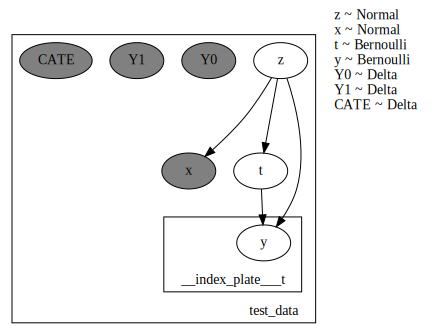

In [7]:
class CEVAE_CATE(PyroModule):
    def __init__(self, individual_model: ProxyConfounderModel):
        super().__init__()
        self.individual_model = individual_model

    @pyro.infer.config_enumerate
    def forward(self, x_pred):
        # As we're evaluating the CATE, we need to condition on the observed data at test time.
        with MultiWorldCounterfactual(), \
                do(actions=dict(t=(0., 1.))), \
                condition(data=dict(x=x_pred)), \
                pyro.plate("test_data", size=x_pred.shape[0], dim=-1):
            
            Ys_pred = self.individual_model()
            Y0 = pyro.deterministic("Y0", gather(Ys_pred, IndexSet(t={1})), event_dim=0)
            Y1 = pyro.deterministic("Y1", gather(Ys_pred, IndexSet(t={2})), event_dim=0)
            return pyro.deterministic("CATE", Y1 - Y0, event_dim=0)


cate_model = CEVAE_CATE(individual_model)
pyro.render_model(cate_model, model_args=(x_train,), render_distributions=True)

## Causal Inference as Probabilistic Inference

In the [backdoor](backdoor.ipynb) and [slc](slc.ipynb) examples we only used Pyro's approximate inference utilities to estimate posterior distributions over model parameters, and then used those inferred (distributions over) parameters to estimate causal effects using ChiRho's interventions. Here the story is somewhat more complicated by the fact that we are estimating the conditional average treatment effect for yet unseen test data. Therefore, not only do we need to estimate model parameters as we've done above, but also we must estimate posterior distributions over latent $Z$ conditional on observed covariates $X$. Similar to previous example, any inference method available in Pyro could be used to estimate the CATE, including amortized variational inference \[Kingma and Welling, 2013\] as in the original paper \[Louizos et al., 2017\].



In [8]:
class LightningSVITest(pl.LightningModule):
    def __init__(self, elbo: pyro.infer.elbo.ELBOModule, pre_whitener: PreWhitener, **optim_params):
        super().__init__()
        self.optim_params = dict(optim_params)
        self.elbo = elbo
        self.pre_whitener = pre_whitener

    def configure_optimizers(self):  # only optimize guide parameters at test time
        return torch.optim.Adam(self.elbo.guide.parameters(), **self.optim_params)

    def training_step(self, batch, batch_idx):
        x_data, = batch
        return self.elbo(self.pre_whitener(x_data))

cate_model = cate_model.requires_grad_(False)
cate_guide = pyro.infer.autoguide.AutoNormal(pyro.poutine.block(cate_model, hide=['t', 'y']))
elbo = pyro.infer.TraceEnum_ELBO()(cate_model, cate_guide)

# initialize parameters
elbo(x_test)

# data
pre_whitener = PreWhitener(x_test)
test_dataset = torch.utils.data.TensorDataset(x_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=x_test.shape[0])

# fit parameters
svi_test = LightningSVITest(elbo, pre_whitener, lr=1e-3, weight_decay=1e-4)
trainer = pl.Trainer(max_epochs=2500, log_every_n_steps=1, accelerator='cpu') # issue w/ using GPU on new macbook
trainer.fit(svi_test, train_dataloaders=test_dataloader)

/home/rafal/.local/lib/python3.10/site-packages/pyro/primitives.py:443: UserWarning: 0.weight was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
/home/rafal/.local/lib/python3.10/site-packages/pyro/primitives.py:443: UserWarning: 0.bias was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
/home/rafal/.local/lib/python3.10/site-packages/pyro/primitives.py:443: UserWarning: 2.weight was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
/home/rafal/.local/lib/python3.10/site-packages/pyro/primitives.py:443: UserWarning: 2.bias was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
/home/rafal/.local/lib/python3.10/site-p

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2500` reached.


## Results

To analyze the results of inference, we generate samples from the posterior predictive distribution over counterfactual outcomes, and then compute estimated causal effects with simple arithmetic operations.

In [9]:
# Generate samples from the posterior predictive distribution
predictive = pyro.infer.Predictive(cate_model, guide=cate_guide, num_samples=500, parallel=False)
preds = predictive(x_test)
ys_diff, t_pred, zs_pred = preds["CATE"], preds["t"], preds["z"]

# Evaluate the c-specific causal effects for each individual and for each posterior sample
est_cates = ys_diff.mean(0).squeeze()

# Evaluate the average causal effect by taking the mean over the individual-specific effects
# ate = est_cates.mean(0)
true_ate = true_cates.mean()
est_ate = ys_diff.mean(-1).squeeze()

mae_ate = torch.abs(true_cates - est_cates).mean()
print(f"Mean absolute error for ATE: ", mae_ate)

Mean absolute error for ATE:  tensor(0.0267)


As the synthetic data assumes a boolean random variable for the latent confounder, each instance with $Z=0$ (and analogously for $Z=1$) has exactly the same ground-truth value for the CATE. Therefore,
to compare our estimates with the ground truth we can simply partition our test data based on the true value of $Z$.

In [10]:
est_cates_z0, true_cates_z0 = est_cates[z_test == 0], true_cates[z_test == 0]
est_cates_z1, true_cates_z1 = est_cates[z_test == 1], true_cates[z_test == 1]

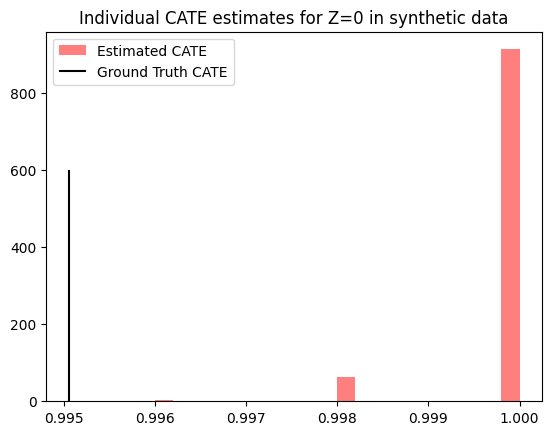

In [11]:
plt.hist(est_cates_z0.detach().cpu().numpy(), bins=20, color='red', label="Estimated CATE", alpha=0.5)
plt.vlines(true_cates_z0.mean().item(), 0, 600, color="black", label="Ground Truth CATE")
plt.title(f'Individual CATE estimates for Z=0 in synthetic data')
# plt.xlim(0.9, 1.05)
plt.legend()

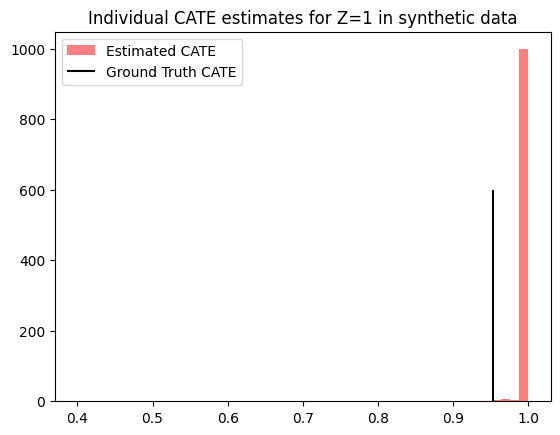

In [12]:
plt.hist(est_cates_z1.detach().cpu().numpy(), bins=50, color='red', label="Estimated CATE", alpha=0.5)
plt.vlines(true_cates_z1.mean().item(), 0, 600, color="black", label="Ground Truth CATE")
plt.title(f'Individual CATE estimates for Z=1 in synthetic data')
# plt.xlim(0.9, 1.05)
plt.legend()

Similarly, we can estimate the average treatment effect by further aggregating the individual-level differences in counterfactual outcomes.

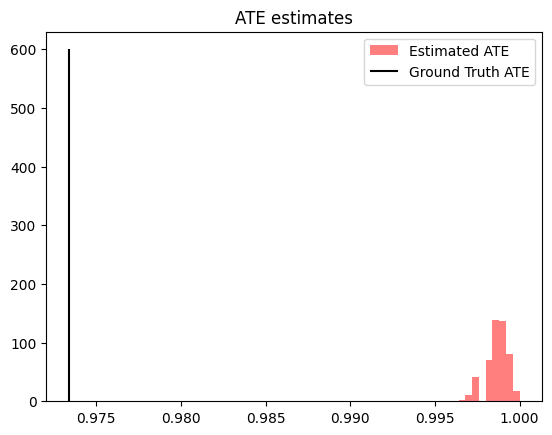

In [13]:
plt.hist(est_ate.detach().cpu().numpy(), bins=10, color='red', label="Estimated ATE", alpha=0.5)
plt.vlines(true_ate.item(), 0, 600, color="black", label="Ground Truth ATE")
plt.title(f'ATE estimates')
# plt.xlim(0.9, 1.05)
plt.legend()

While the posterior predictive distribution for ATE estimates does not cover the ground truth ATE, we can see that the estimates are still relatively close in total magnitude. As we discussed in the beginning of this example, misspecification of the latent confounder (as we do here) can result in inaccurate causal effect estimates.

## References

Kingma, Diederik P, and Max Welling. “Auto-Encoding Variational Bayes,” 2013. https://doi.org/10.48550/ARXIV.1312.6114.

Kuroki, Manabu, and Judea Pearl. "Measurement bias and effect restoration in causal inference." Biometrika 101.2 (2014): 423-437.

Louizos, Christos, Uri Shalit, Joris Mooij, David Sontag, Richard Zemel, and Max Welling. “Causal Effect Inference with Deep Latent-Variable Models.” arXiv, November 6, 2017. http://arxiv.org/abs/1705.08821.

Rissanen, Severi, and Pekka Marttinen. "A critical look at the consistency of causal estimation with deep latent variable models." Advances in Neural Information Processing Systems 34 (2021): 4207-4217.